# 无人车车道线检测挑战赛
Project from [Baidu AI Competition](https://aistudio.baidu.com/aistudio/competition/detail/5/0/introduction):
>在无人驾驶汽车研究领域，带有车道线属性的高精地图是商业无人驾驶的一个非常关键的环节。截止目前，大多数的高精地图都是靠人工标注来完成的。人工标注不仅效率低，而且成本高不适宜大规模的商业应用。在高精地图的生产过程中，如何从图像中分割出不同类型的车道线是非常重要的一个环节。同时，准确分割车道线也会为将来高精地图的更新提供帮助。本次无人车车道线检测挑战赛旨在为参赛者提供一定数量的准确的车道线标注数据，让更多的研究者参与并设计出高效、准确的检测算法，以此来共同推动无人车的发展，从而造福整个社会。

项目过程中的主要困难点、亮点和相关方案：
- 数据读取：数据量大，使用LMDB内存映射型数据库，通过内存映射的方式访问文件，最小化系统I/O访问耗时，速度加快6.25%
- 模型结构：设计组合ResNet、Deeplabv3p、UNet、UNetpp等不同搭配的模型
- 消融实验：对比在不同模型结构、损失函数等设置下的Mean iou，验证cross entropy，focal和dice loss在weighted/non-weighted等不同搭配情况下的训练情况，逐步调整模型优化策略
- 模型加速：通过调节各种参数，充分利用GPU提速，利用率长期稳定在100%左右
- 项目整合：整合项目所有文件和参数配置，方便在终端通过命令或执行脚本指定参数，从而开启自定义训练
- 模型部署：整合预训练模型，并通过class实例化调用，可用于预测图片和视频，同时制作简单的网页端demo

In [2]:
# Analysis
import os
import glob
import numpy as np
import pandas as pd

# Plotting
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import torch
from torch import nn
import torch.nn.functional as F

- 数据处理： oom，读取数据，gpu并行
- 模型：提高精度，基于deeplabv3+
- 调参数：消融实验，对filters数，结构
- 部署压缩：

>### Data

#### Lane Dataset

`preprocess/load_data.py`

下载初赛[训练集](https://aistudio.baidu.com/aistudio/datasetDetail/1919)和[测试集](https://aistudio.baidu.com/aistudio/datasetDetail/2492)车道线数据，共21,914组训练数据和999组测试数据。此数据采集于北京和上海两个不同的城市，几种不同的交通场景，包含了绝大多数的道路标识以及一些不常见的类别。所有的车道线标注都是在三维点云上完成的，然后投影到二维的图像上，包括彩色原图以及对应的车道线标注Mask(彩色和灰色)，Mask中像素值对应的是此像素属于的相应的类别。

训练数据的文件夹结构如下：{根目录} {道路名称}{类型}{Record 标识}{相机标号}{时间戳}_{相机标号}{额外信息}

|Path|Details|
|--|--|
|根目录|存放数据的根目录|
|类型|数据类型分为两类分别是“ColorImage” and “Labels”|
|道路标示|采集道路的标识，如. “road02”|
|Record标示|由采集系统定义的部分数据集的文件夹名称，如. “road02”|
|相机标号|由采集系统定义的相机的名称，如. “Camera 5” 和“Camera 6”|
|时间戳|采集图像的时间|
|额外信息|图像的扩展名，如对于彩色像的扩展名为’.jpg’, 对于标注的标签信息的扩展名为’.png’|


```
Train 
    ├─ Gray_Label #灰色mask
    │     ├─ Label_road02
    │     │      └─ Label
    │     │          ├─ Record001
    │     │          │     ├─ Camera5
    │     │          │     │     ├─ 170927_063820123_Camera_5_bin.png
    │     │          │     │     └─ 170927_063843458_Camera_5_bin.png
    │     │          │     └─ Camera6
    │     │          │     │     └─ 170927_063844445_Camera_6_bin.png
    │     │          └─ ...
    │     ├─ Label_road03
    │     │      └─ ...
    │     └─ ...
    ├─ Road02
    │     ├─ ColorImage_road02
    │     │      └─ ColorImage #彩色原图
    │     │          ├─ Record001
    │     │          │     ├─ Camera5
    │     │          │     │     ├─ 170927_063820123_Camera_5.jpg
    │     │          │     │     └─ 170927_063843458_Camera_5.png
    │     │          │     └─ Camera6
    │     │          │     │     └─ 170927_063844445_Camera_6.png
    │     │          └─ ...
    │     └─Labels_road02
    │            └─ Label #彩色mask
    │                ├─ Record001
    │                │     ├─ Camera5
    │                │     │     ├─ 170927_063820123_Camera_5_bin.png
    │                │     │     └─ 170927_063843458_Camera_5_bin.png
    │                │     └─ Camera6
    │                │     │     └─ 170927_063844445_Camera_6_bin.png
    └─ Road03
          ├─ ...
          └─ ...
```

In [24]:
from sklearn.model_selection import train_test_split

In [22]:
# 查看数据路径形式
DATA_ROOT = 'dataset'
TRAIN_PATH = 'Train' 
TEST_PATH = 'Test' #全是彩图

In [304]:
#彩图，彩mask和灰mask
glob.glob(os.path.join(DATA_ROOT, TRAIN_PATH,'Road02','**'), recursive=True)[:6]
glob.glob(os.path.join(DATA_ROOT, TRAIN_PATH,'Road02','**'), recursive=True)[-4:]
glob.glob(os.path.join(DATA_ROOT, TRAIN_PATH,'Gray_Label', 'Label_road02','**'), recursive=True)[:5]

['dataset/Train/Road02/',
 'dataset/Train/Road02/Labels_road02',
 'dataset/Train/Road02/Labels_road02/Label',
 'dataset/Train/Road02/Labels_road02/Label/Record005',
 'dataset/Train/Road02/Labels_road02/Label/Record005/Camera 6',
 'dataset/Train/Road02/Labels_road02/Label/Record005/Camera 6/170927_064344170_Camera_6_bin.png']

['dataset/Train/Road02/ColorImage_road02/ColorImage/Record007/Camera 5',
 'dataset/Train/Road02/ColorImage_road02/ColorImage/Record007/Camera 5/170927_064609771_Camera_5.jpg',
 'dataset/Train/Road02/ColorImage_road02/ColorImage/Record007/Camera 5/170927_064655874_Camera_5.jpg',
 'dataset/Train/Road02/ColorImage_road02/ColorImage/Record007/Camera 5/170927_064651106_Camera_5.jpg']

['dataset/Train/Gray_Label/Label_road02/',
 'dataset/Train/Gray_Label/Label_road02/Label',
 'dataset/Train/Gray_Label/Label_road02/Label/Record005',
 'dataset/Train/Gray_Label/Label_road02/Label/Record005/Camera 6',
 'dataset/Train/Gray_Label/Label_road02/Label/Record005/Camera 6/170927_064344170_Camera_6_bin.png']

In [307]:
#全是彩图
glob.glob(os.path.join(DATA_ROOT, TEST_PATH, '**'), recursive=True)[:4]

['dataset/Test/',
 'dataset/Test/171206_064733474_Camera_5.jpg',
 'dataset/Test/171206_064731347_Camera_5.jpg',
 'dataset/Test/171206_064731347_Camera_6.jpg']

In [20]:
# 根据路径创建一一对应的data list，路径是从road->record->camera，这里只要灰色mask的路径
def create_data_list(path, train_size=0.8):
    image_path_pattern = os.path.join(path, 'Road**','ColorImage_road**','**','**.jpg') #遍历彩图下所有jpg文件
    color_mask_path_pattern = os.path.join(path, 'Road**','Labels_road**','**','**_bin.png') #遍历彩mask下所有png文件
    mask_path_pattern = os.path.join(path, 'Gray_Label','**','**_bin.png') #遍历灰mask下所有png文件
    image_paths = sorted(glob.glob(image_path_pattern,recursive=True)) #路径按顺序排序
    color_mask_paths = sorted(glob.glob(color_mask_path_pattern,recursive=True))
    mask_paths = sorted(glob.glob(mask_path_pattern,recursive=True))

    train_img, test_img, train_color_mask, test_color_mask, train_mask, test_mask  = train_test_split(image_paths, color_mask_paths, mask_paths, train_size=train_size, shuffle=True)
    train = pd.DataFrame({'images':train_img, 'color_labels': train_color_mask, 'labels':train_mask})
    test = pd.DataFrame({'images':test_img, 'color_labels': test_color_mask, 'labels':test_mask})
    train.to_csv(os.path.join(DATA_ROOT, 'train.csv'), index=False)
    test.to_csv(os.path.join(DATA_ROOT, 'test.csv'), index=False)
    print(f'We have created {len(train)} samples for training, and {len(test)} samples for validation.')
    return train, test

In [25]:
train, test = create_data_list(os.path.join(DATA_ROOT, TRAIN_PATH))
train.head()

We have created 80 samples for training, and 20 samples for validation.


,images,color_labels,labels
0,dataset/Train/Road03/ColorImage_road03/ColorIm...,dataset/Train/Road03/Labels_road03/Label/Recor...,dataset/Train/Gray_Label/Label_road03/Label/Re...
1,dataset/Train/Road04/ColorImage_road04/ColorIm...,dataset/Train/Road04/Labels_road04/Label/Recor...,dataset/Train/Gray_Label/Label_road04/Label/Re...
2,dataset/Train/Road04/ColorImage_road04/ColorIm...,dataset/Train/Road04/Labels_road04/Label/Recor...,dataset/Train/Gray_Label/Label_road04/Label/Re...
3,dataset/Train/Road04/ColorImage_road04/ColorIm...,dataset/Train/Road04/Labels_road04/Label/Recor...,dataset/Train/Gray_Label/Label_road04/Label/Re...
4,dataset/Train/Road03/ColorImage_road03/ColorIm...,dataset/Train/Road03/Labels_road03/Label/Recor...,dataset/Train/Gray_Label/Label_road03/Label/Re...


In [313]:
# 随机查看样本
def show_sample(data, idx): #显示图片/mask
    # 随机查看样本
    image = plt.imread(data['images'][idx])
    color_mask = plt.imread(data['color_labels'][idx]) #混合单通道和4通道图
    gray_mask = plt.imread(data['labels'][idx]) #33个类别 [0,1] 
    images = [image, color_mask, gray_mask]
    plt.figure(figsize=(15,8))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(images[i], cmap='gray') 
        plt.title(f'{images[i].shape}, {images[i].dtype}')
        plt.axis('off')

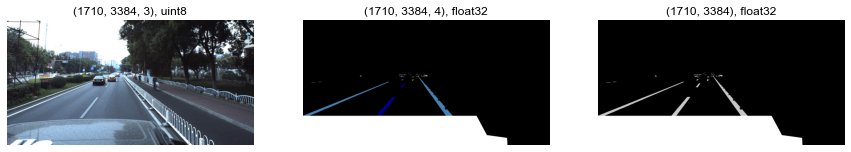

In [314]:
idx = np.random.choice(train.shape[0])
show_sample(train, idx)

#### LMDB
`preprocess/create_lmdb.py`   

Lightning Memory-Mapped Database 内存映射型数据库，提供key-value分布式存储，其中每个键值对都是我们数据集中的一个样本。让系统访问大量小文件的开销很大，而LMDB使用内存映射的方式访问文件，使得文件内寻址的开销非常小，使用指针运算就能实现。

1. 为了对比加载数据的速度，通过创建循环遍历Test loader共1096个batches，CPU环境单线程加载耗时对比如下：
    - 直接从硬盘读取文件：耗时8分半钟
    - 用LMDB映射加载：耗时刚好8分钟，速度要快6.25%

2. 当用多进程从LMDB加载数据时，报错`lmdb.InvalidParameterError: mdb_txn_begin: Invalid argument`。搜索发现，这可能是因为多进程同时执行`lmdb.open`打开数据库后，某些进程执行env.close()，导致下一个进程无法正常读写：
    ```
    process 1: open db
    process 2: open db
    process 2: make a read/write transaction
    process 2: close db
    process 1: make a read/write transaction and has failed
    ```

In [78]:
import lmdb
from tqdm import tqdm

In [79]:
LMDB_PATH = 'LMDB'

In [80]:
#将image和label图写入LMDB结构中，key{image,label}，value{图片的二进制值}
def path2LMDB(data, mode='train'):
    if not os.path.exists(os.path.join(DATA_ROOT, LMDB_PATH, mode)): #先判断是否存在文件夹，再新建，否则覆盖
        os.makedirs(os.path.join(DATA_ROOT, LMDB_PATH, mode)) 
    
    #创建LMDB文件的环境路径，或者用with lmdb.open as env: 此处因为都写入同个path就不重复初始化环境
    #map_size定义最大储存容量，单位是b，以下定义1TB容量2**40b，否则容易爆limit
    env = lmdb.open(os.path.join(DATA_ROOT, LMDB_PATH, mode), map_size=2**40)
    
    # 方法一：数据少时，直接df.apply得到二进制，然后cache=dict(zip(key,value))，但是空间复杂度高
    # 方法二：数据多时，为了防止爆内存，逐个样本cache，但是时间复杂度高
    for i in tqdm(range(data.shape[0])):
        cache = {}  
        with open(data['images'][i],'rb') as f:
            value = f.read() #得到二进制图片
            cache[data['images'][i].encode()] = value #把路径作为key，不容易混乱，也转为二进制utf8字符串
 
        with open(data['labels'][i],'rb') as f:
            value = f.read() 
            cache[data['labels'][i].encode()] = value 
        
        #写入文件，或者用txn=env.begin，结束后txn.commit()
        with env.begin(write=True) as txn: 
            for k, v in cache.items():
                txn.put(k, v) #写入/更新字典，还有其他常用指令如txn.delete(k),txn.cursor()类似dict.items()
    env.close() #如果写成with格式，就不需要

In [83]:
# 得到两个mdb文件
path2LMDB(train, 'train')
path2LMDB(val, 'test')
os.listdir(os.path.join(DATA_ROOT, LMDB_PATH,'train'))

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 342.23it/s]


['lock.mdb', 'data.mdb']

In [84]:
#从lmdb文件中读取图片
def LMDB2image(image_path, label_path, mode):
    env = lmdb.open(os.path.join(DATA_ROOT, LMDB_PATH, mode))
    with env.begin(write=False) as txn: #读取非写入
        # 读取字典，得到二进制图片和label mask
        image_bin = txn.get(image_path.encode())
        label_bin = txn.get(label_path.encode()) 

        # 将数组解码成(h,w,c)的(0,255)的uint8数组，label从float转为uint8
        image = np.array(bytearray(image_bin), dtype=np.uint8) #二进制->一维数组
        label = np.array(bytearray(label_bin), dtype=np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR) #(h,w,3)
        label = cv2.imdecode(label, cv2.IMREAD_GRAYSCALE) #(h,w)
    env.close()
    return image, label

In [85]:
def show_sample(data, idx, mode='train'):
    image_path = data['images'][idx]
    label_path = data['labels'][idx]
    image, mask = LMDB2image(image_path, label_path, mode)
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(image[...,::-1]) 
    plt.title(f'{image.shape}, {image.dtype}')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask,cmap='gray') 
    plt.title(f'{mask.shape}, {mask.dtype}');
    plt.axis('off')
    plt.show()

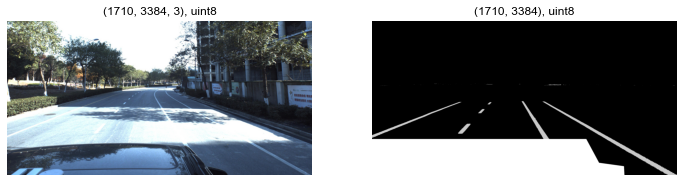

In [86]:
idx = np.random.choice(train.shape[0])
show_sample(train, idx)

>### Mask

`preprocess/mask.py`

#### Convert Mask
原数据按车道线颜色、形状等标注了33个类别，本项目只需要把对应的`id`类别合并为8类`train_id`：

| Column | Details |
|----|--|
|"name"|代表此类别的名字，其中，"s" 代表singe， "d" 代表double"w", 代表white， "y" 代表yellow|
|"id"|代表的是标注时候的Id,也是现在发布数据中的class Id|
|"trainId"|代表的是建议的training Id。 在进行训练的过程中，数据的classId要是连续的整数。所以需要把label图像中的标注Id转化为trainId进行训练|
|"category"|代表的是不同的类别的具体含义|
|"catId"|代表的不同的不同的类别的Id，在这里我们的training Id 与 catId相同|
|"hasInstances"|代表这个类别是不是示例级别，这个在此task中并无实际意义。主要是与cityscape的mapping format保持一致|
|"ignoreInEval"|代表这个类别在评估时，是否忽略。请注意，不是所有的类别都在最终的结果中进行评估。原因是，有一些类别在此数据集中并不存在|
|"color"|代表不同的class对应的color map|

<img src='note/original_label.png'></img>

In [30]:
# 根据8个类别的对应原label列表，把mask的原label转为新label
def convert_labels(mask): 
    encode_mask = np.zeros(mask.shape, dtype='uint8') #(h,w)
    id_train = {0:[0, 249, 255, 213, 206, 207, 211, 208,216,215,218, 219,232, 202, 231,230,228,229,233,212,223],
                1:[200, 204, 209], 2: [201,203], 3:[217], 4:[210], 5:[214],
                6:[220,221,222,224,225,226], 7:[205,227,250]}
    for i in range(8):
        for label in id_train[i]:
            encode_mask[mask == label] = i
    return encode_mask

In [31]:
# 可视化mask
def mask2gray(mask): #用灰度图显示mask
    color_map = {0:0, 1:204, 2:203, 3:217, 4:210, 5:214, 6:224, 7:227}
    gray_mask = np.zeros(mask.shape, dtype='uint8')
    
    for i in range(8):
        gray_mask[mask == i] = color_map[i]
    return gray_mask


def mask2color(mask): #用RGB显示mask
    # 统一用原label里第一个color map作为每个新label的颜色
    color_map = {0:(0,0,0), 1:(70,130,180), 2:(0,0,142), 3:(153,153,153),
                 4:(128,64,128), 5:(190,153,153), 6:(0,0,230), 7:(255,128,0)}
    color_mask = np.zeros((mask.shape[0], mask.shape[1],3), dtype='uint8')
    
    for c in range(3):
        for i in range(8):
            color_mask[...,c][mask == i] = color_map[i][c]
    return color_mask

In [32]:
def show_mask(data, idx):
    label_path = data['labels'][idx]
    mask = plt.imread(label_path) #33个类别 [0,1] 
    mask = (mask*255).astype('uint8') #[0,255]
    en_mask = convert_labels(mask) #8个类别
    gray_mask = mask2gray(en_mask)
    color_mask = mask2color(en_mask)
    masks = [mask, en_mask, gray_mask, color_mask]
    titles = ['Original mask','Training mask','Gray Visualiazation','Color Visualization']
    
    plt.figure(figsize=(15,8))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(masks[i],cmap='gray') 
        plt.title(titles[i])
        plt.axis('off')

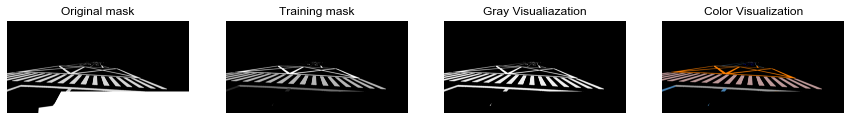

In [316]:
idx = np.random.choice(train.shape[0])
show_mask(train, idx)

#### Check Label Distribution

In [27]:
from tqdm import tqdm

In [28]:
def check_labels(data, num, mode='train'): #随机查看mask的label分布情况
    labels = np.zeros(8)
    idx = np.random.choice(data.shape[0], num, replace=False)
    for i in tqdm(idx): 
        mask = plt.imread(data['labels'][i]) #33个类别 [0,1] 
        mask = (mask*255).astype('uint8')
        mask = convert_labels(mask) #8个类别
        for i in range(8):
            labels[i]+=np.sum(mask==i)

    #忽略最多的label 0，按频数可视化
    plt.bar(np.arange(1,8), labels[1:]) #忽略最多的label 0
    plt.title(f'{mode} set @ {num} samples'.capitalize())
    plt.savefig(f'{mode}_distribution.jpg')
    plt.show()

100%|███████████████████████████████████████████| 80/80 [00:21<00:00,  3.80it/s]


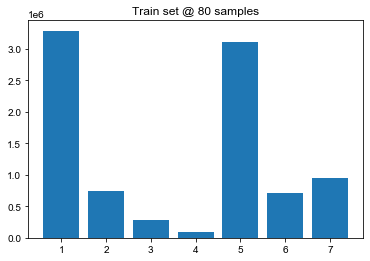

In [33]:
# imbalanced classes
check_labels(train, 80, 'train')

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


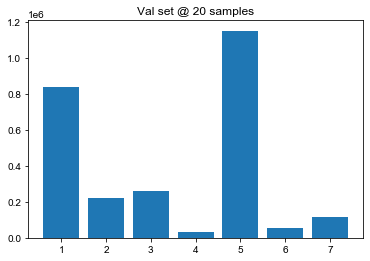

In [35]:
check_labels(test, 20, 'val')

#### Create Mask
以下纯粹说明标注mask的流程

In [103]:
import json
from collections import defaultdict

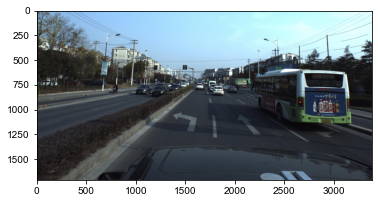

In [99]:
img_path = 'label/171206_054430023_Camera_5.jpg'
img = plt.imread(img_path)
plt.imshow(img);

In [100]:
# 首先利用LabelMe等软件标注每张图片，得到json文件：车道线方向(label)，组成车道线多边形的点等
ann_path = 'label/171206_054430023_Camera_5.json'
with open(ann_path, 'r') as f:
    ann = json.load(f)
ann

{'version': '4.2.9',
 'flags': {},
 'shapes': [{'label': 'left',
   'points': [[1586.3468634686346, 1222.509225092251],
    [1615.129151291513, 1086.7158671586717],
    [1453.5055350553505, 1045.7564575645756],
    [1466.111111111111, 1028.6666666666667],
    [1375.0, 1055.3333333333333],
    [1412.5461254612546, 1100.738007380074],
    [1429.520295202952, 1076.0147601476015],
    [1554.6125461254612, 1107.0110701107012],
    [1516.2361623616237, 1219.1881918819188]],
   'group_id': None,
   'shape_type': 'polygon',
   'flags': {}},
  {'label': 'straight',
   'points': [[2264.457831325301, 1255.421686746988],
    [2126.5060240963853, 1110.8433734939758],
    [2164.457831325301, 1112.6506024096384],
    [2045.691382765531, 1050.7014028056112],
    [2027.7108433734938, 1106.6265060240962],
    [2076.5060240963853, 1109.6385542168673],
    [2189.7610921501705, 1249.4880546075085]],
   'group_id': None,
   'shape_type': 'polygon',
   'flags': {}}],
 'imagePath': '171206_054430023_Camera_5.

In [104]:
def poly2mask(ann_path):
    with open(ann_path, 'r') as f:
        ann = json.load(f)
        
    # 创建黑底的annot mask
    h, w = ann['imageHeight'], ann['imageWidth'] #原图大小
    mask = np.zeros((h, w), dtype=np.uint8) 
    
    # 标注多边形
    polys = defaultdict(list) #多边形列表，每个元素为一个多边形的端点
    i = 0
    for poly_ann in ann['shapes']:
        if poly_ann['shape_type'] != 'polygon': #只画多边形
            continue
        poly = np.array(poly_ann['points']).astype(np.int64) #把点转为int
        polys[poly_ann['label']].append(poly) #放到不同label下
        i+=1
        
    # 填充颜色
    color_map = {'left':100, 'straight':255}
    for label in polys:
        color = color_map[label] #不同label标注不同颜色
        cv2.fillPoly(mask, polys[label], color) #用255白色填充多个多边形
    
    # 保存mask
    save_path = os.path.splitext(ann_path)[0]+'.png' #xxx.png
    cv2.imwrite(save_path, mask)
    print(f"There are {i} lanes detected.")
    return mask

There are 2 lanes detected.


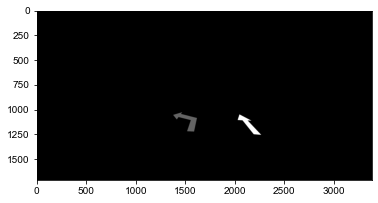

In [105]:
mask = poly2mask(ann_path)
plt.imshow(mask, cmap='gray');

>### Image

`preprocess/image.py`

#### Process Image

In [106]:
OFFSET = 690 #裁掉原图h上半部分天空的长度
IMAGE_SIZE = (3384, 1710) #包括天空的原图大小 
INPUT_SIZE = (1024, 384) #剪裁resize后输入模型的图片大小

In [107]:
# 剪裁原图，把图片上半部分亮色天空去掉，免得影响识别白色车道线，再resize：(w,h)->(w,h‘)->(tw,th)
def crop_and_resize(image, mask=None):
    roi_image = image[OFFSET:, :] #只取图片下半部分
    if mask is not None:
        roi_mask = mask[OFFSET:, :] #label同样处理
        image = cv2.resize(roi_image, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(roi_mask, INPUT_SIZE, interpolation=cv2.INTER_NEAREST) #因为label是特定数字，不能用其他计算的方式
        return image, mask
    else:
        image = cv2.resize(roi_image, INPUT_SIZE, interpolation=cv2.INTER_LINEAR)
        return image

In [108]:
# 再把预测mask重新恢复原图大小：(tw,th)->(w,h')->(w,h)
def expand_resize_mask(mask, size=IMAGE_SIZE, offset=OFFSET):
    pred_mask = mask2gray(mask) 
    expand_mask = cv2.resize(pred_mask, (size[0], size[1]-offset), interpolation=cv2.INTER_NEAREST)
    mask = np.zeros((size[1], size[0]), dtype='uint8')
    mask[offset:, :] = expand_mask #还原原图裁掉上半部分，并默认为黑色，下半部分拼接
    return mask

def expand_resize_color_mask(mask, size=IMAGE_SIZE, offset=OFFSET):
    color_pred_mask = mask2color(mask) #得到RGB的array图
    color_expand_mask = cv2.resize(color_pred_mask, (size[0], size[1] - offset), interpolation=cv2.INTER_NEAREST)
    color_mask = np.zeros((size[1], size[0], 3), dtype='uint8')
    color_mask[offset:, :, :] = color_expand_mask
    return color_mask

In [339]:
# 随机查看resize后的样本
def show_sample(data, idx, color_mode=True): 
    image = plt.imread(data['images'][idx])
    mask = plt.imread(data['labels'][idx]) #33个类别 [0,1] 
    mask = (mask*255).astype('uint8')
    mask = convert_labels(mask) #8个类别
    resize_image, resize_mask = crop_and_resize(image, mask) 
    if color_mode:
        expand_mask = expand_resize_color_mask(resize_mask) #真正用于预测的true mask
    else:
        expand_mask = expand_resize_mask(resize_mask)
    images = [resize_image, resize_mask, image, expand_mask] 
    
    plt.figure(figsize=(15,8))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i], cmap='gray') 
        plt.title(f'{images[i].shape}, {images[i].dtype}')
        plt.axis('off')

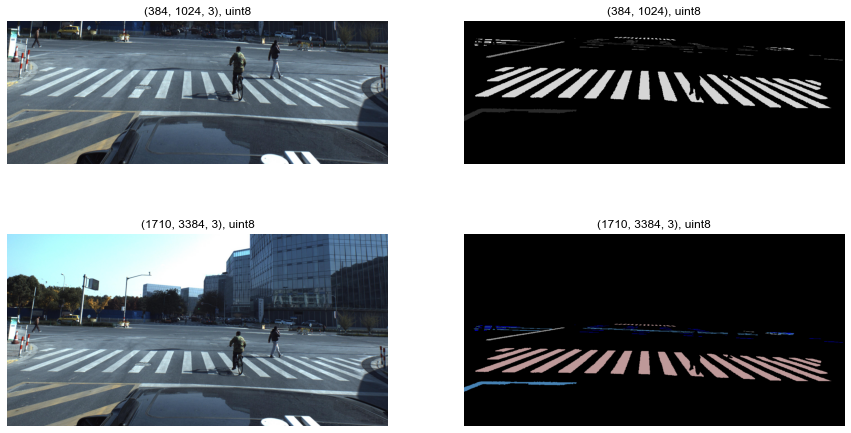

In [334]:
idx = np.random.choice(train.shape[0])
show_sample(train, idx)

In [ ]:
# 把gray mask转化为expand mask，即预测mask的true mask
def get_true_mask(path, color_mode=True): 
    image = np.random.rand(IMAGE_SIZE[1],IMAGE_SIZE[0],3) #fake
    mask = plt.imread(path) #33个类别 [0,1] 
    mask = (mask*255).astype('uint8')
    mask = convert_labels(mask) #8个类别
    resize_image, resize_mask = crop_and_resize(image, mask) 
    if color_mode:
        expand_mask = expand_resize_color_mask(resize_mask) #rgb
    else:
        expand_mask = expand_resize_mask(resize_mask)
    expand_mask = cv2.cvtColor(expand_mask, cv2.COLOR_RGB2BGR) #把mask从RGB转为BGR
    save_path = os.path.splitext(path)[0]+'_converted.png'
    cv2.imwrite(save_path, expand_mask)

#### Data Augmentation
`preprocess/augmentation.py`

为了使模型对复杂的道路情况鲁棒性更强，从噪点、对比度、随机剪切、缩放、遮挡等方面做了图片增强

In [111]:
from imgaug import augmenters as iaa

In [131]:
def ImageAug(image, mask): #增强image
    if np.random.rand() > 0.5: #一半机会
        seq = iaa.Sequential([iaa.OneOf([ #任意一个
            iaa.AdditiveGaussianNoise(scale=(0, 0.2 * 255)),
            iaa.Sharpen(alpha=(0.1, 0.3), lightness=(0.7, 1.3)),
            iaa.GaussianBlur(sigma=(0, 1.0))])])
        image = seq.augment_image(image)
    return image, mask


def DeformAug(image, mask): #随机剪裁image和mask
    seq = iaa.Sequential([ #随机对w,h两边同时crop 0-5%或者pad 0-10%
        iaa.CropAndPad(percent=(-0.05, 0.1))]) #随机范围
    #默认是stochastic随机状态，转成deterministic相当于每个batch内固定random seed，用相同的随机值
    seg_to = seq.to_deterministic() 
    image = seg_to.augment_image(image)
    mask = seg_to.augment_image(mask)
    return image, mask


def ScaleAug(image, mask): #缩放image和mask
    scale = np.random.uniform(0.7, 1.5)
    h, w, _ = image.shape
    aug_image = image.copy()
    aug_mask = mask.copy()
    aug_image = cv2.resize(aug_image, (int(scale * w), int(scale * h)), interpolation=cv2.INTER_LINEAR)
    aug_mask = cv2.resize(aug_mask, (int(scale * w), int(scale * h)), interpolation=cv2.INTER_NEAREST)
    if (scale < 1.0): #如果缩小，用pad维持原图大小
        new_h, new_w, _ = aug_image.shape
        pre_h_pad = int((h - new_h) / 2)
        pre_w_pad = int((w - new_w) / 2)
        pad_list = [[pre_h_pad, h - new_h - pre_h_pad], [pre_w_pad, w - new_w - pre_w_pad], [0, 0]]
        aug_image = np.pad(aug_image, pad_list, mode="constant")
        aug_mask = np.pad(aug_mask, pad_list[:2], mode="constant")
    if (scale > 1.0): #如果放大，crop掉两边维持原图大小
        new_h, new_w, _ = aug_image.shape
        pre_h_crop = int ((new_h - h) / 2)
        pre_w_crop = int ((new_w - w) / 2)
        post_h_crop = h + pre_h_crop
        post_w_crop = w + pre_w_crop
        aug_image = aug_image[pre_h_crop:post_h_crop, pre_w_crop:post_w_crop]
        aug_mask = aug_mask[pre_h_crop:post_h_crop, pre_w_crop:post_w_crop]
    return aug_image, aug_mask

    
def CutOut(image, mask): #随机挖空image，模拟遮挡
    patch_size=32 #遮挡的方块边长
    patch_size_half = patch_size // 2
    offset = 1 if patch_size % 2 == 0 else 0 #偶数边长，offset 1，因为randint不取后面值[)
    h, w = image.shape[:2] #假设为(100,100)
    #原图两边留一半的patch size为边缘，中间部分随意
    cxmin, cxmax = patch_size_half, w + offset - patch_size_half #(16,85)内
    cymin, cymax = patch_size_half, h + offset - patch_size_half
    cx = np.random.randint(cxmin, cxmax) #方块中心点的位置
    cy = np.random.randint(cymin, cymax)
    xmin, ymin = cx - patch_size_half, cy - patch_size_half #左上角
    xmax, ymax = xmin + patch_size, ymin + patch_size #右下角
    xmin, ymin, xmax, ymax = max(0, xmin), max(0, ymin), min(w, xmax), min(h, ymax)
    
    if np.random.rand() > 0.5: #一半机会
        image[ymin:ymax, xmin:xmax] = (0, 0, 0) #用黑色方块遮挡
    return image, mask


def augumentor(image, mask):
    aug_func = [ImageAug, DeformAug, ScaleAug, CutOut]
    for aug in aug_func:
        image, mask = aug(image, mask)
    return image, mask   

In [113]:
def show_aug(data, aug_func):
    image = plt.imread(data['images'][0])
    mask = plt.imread(data['labels'][0]) #33个类别 [0,1] 
    mask = (mask*255).astype('uint8')
    mask = convert_labels(mask) #8个类别
    image, mask = crop_and_resize(image, mask)
    image, mask = aug_func(image, mask)
    images = [image,mask]
    plt.figure(figsize=(15,4))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i], cmap='gray') 
        plt.title(f'{images[i].shape}, {images[i].dtype}')
        plt.axis('off')
    plt.show()

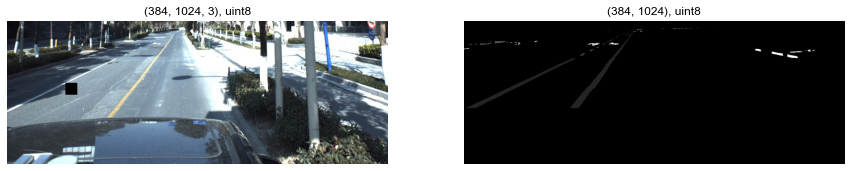

In [118]:
show_aug(train, CutOut)

#### Dataset
`preprocess/dataset.py`

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 

In [125]:
class LaneDataset(Dataset):
    def __init__(self, transform=None, mode='train'):
        super(LaneDataset, self).__init__()
        self.data = pd.read_csv(os.path.join(DATA_ROOT, f'{mode}.csv'), usecols=['images','labels'])
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 读取
        image_path = self.data['images'][idx]
        mask_path = self.data['labels'][idx]
        # image, mask = LMDB2image(image_path, mask_path, self.mode) #(h,w,3),(h,w), uint8
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 处理
        image, mask = crop_and_resize(image, mask) #剪裁天空
        mask = convert_labels(mask) #转成8个类别
        if self.mode=='train':
            image, mask = augumentor(image, mask) #数据增强
        if self.transform:
            image = self.transform(image) #float32, [0,1]
        mask = torch.LongTensor(mask) #int64
        return image, mask

In [126]:
BATCH_SIZE = 8
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [127]:
train_dataset = LaneDataset(transform=train_transform, mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                          drop_last=True, num_workers=0)
valid_dataset = LaneDataset(transform=test_transform, mode='test')
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE//2, 
                          drop_last=False, num_workers=0)

In [129]:
def show_sample(sample):
    image = np.transpose(sample[0].numpy(), (1,2,0))[...,::-1] #(h,w,c), rgb
    mask = sample[1].numpy()
    mask = mask2color(mask) #用彩色查看
    images = [image, mask]
    plt.figure(figsize=(15,4))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i], cmap='gray') 
        plt.title(f'{images[i].shape}, {images[i].dtype}')
        plt.axis('off')
    plt.show()

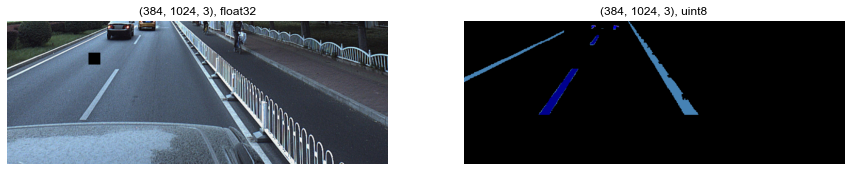

In [137]:
idx = np.random.choice(train_dataset.__len__())
sample = train_dataset[idx]
show_sample(sample)

>### Model

In [3]:
from torchsummary import summary

#### ResNet_Astrous

`model/resnet_astrous.py`

为了能加载Pytorch预训练参数，可以直接从Github复制模型[source codes](https://github.com/pytorch/vision/blob/main/torchvision/models)再做修改，保证除了新结构以外，其余结构名等都不变，否则无法对应加载预训练参数。

In [4]:
import torch.utils.model_zoo as model_zoo

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(BasicBlock, self).__init__()
        #增加dilation_rate做空洞卷积，当kernel_size=3, s=1时，若padding=dilation相当于same conv
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=dilation, dilation=dilation, bias=False) 
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion))

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        #增加dilation_rate做空洞卷积，当kernel_size=3, s=1时，若padding=dilation相当于same conv
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion))

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample is not None:
            residual = self.downsample(residual)
        x += residual
        x = self.relu(x)
        return x

In [7]:
class ResNet_Astrous(nn.Module):
    def __init__(self, block, layers, os=16, dilation=[1,1,1], kernel_size=7, stride=2):
        super(ResNet_Astrous, self).__init__()
        strides = self.get_strides(os, dilation)
        self.block = block #用于后续获取expansion
        
        # Stem
        self.inplanes = 64 #stem后的channel
        #根据downsample需要，可以用7x7搭配stride=2或者3x3搭配stride=1，做same conv
        #由于可能会生成不同结构，不保留原层名
        self.conv = nn.Conv2d(3, 64, kernel_size, stride, padding=kernel_size//2, bias=False) #2倍downsample
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #4倍downsample
        
        #除了layer1因为有事先pooling降维之外，其余layer都是第一个block的stride=2降维，其余blocks的stride=1
        #保留所有层名，方便后续加载预训练参数
        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1]) #8倍downsample
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], 
                                       dilation=16//os) #若8倍下采样，由于不同ResNet结构layer 3的循环次数不同，统一用d=2
        self.layer4 = self._make_layer(block, 512, layers[3], stride=strides[3],
                                       #由于不同ResNet结构layer4都是3次循环，可以自定义每次循环的空洞d，如[1,2,1]
                                       dilation=[i*16//os for i in dilation]) #若8倍下采样，那么这层的dilation要乘以2
        
        # 额外重复2次layer 4结构
        self.layer5 = self._make_layer(block, 512, layers[3], stride=1, dilation=[i*16//os for i in dilation])
        self.layer6 = self._make_layer(block, 512, layers[3], stride=1, dilation=[i*16//os for i in dilation])
   
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def get_strides(self, os, dilation):
        #output_stride 可选下采样倍数os=8/16，传统resnet都是2**5=32倍downsampling
        #由于至少8倍下采样，即对应layer1-2，所以可以用列表指定剩下3个block的dilation
        if os==16 and dilation==[1,1,1]: #代表用传统的32倍downsample，不用空洞卷积
            strides=[1,2,2,2] #layer1-4的stride
        elif os==16: #若16倍downsample，仅最后layer 4 strides=1，可以用空洞卷积
            strides=[1,2,2,1] 
        elif os==8: #若8倍downsample，最后layer 3-4 strides=1，可以用空洞卷积
            strides=[1,2,1,1] 
        return strides
    
    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        if isinstance(dilation, int): #根据具体循环次数构造
            dilation=[dilation]*blocks  
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=dilation[0]))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks): #跳过第一个block
            layers.append(block(self.inplanes, planes, dilation=dilation[i]))
        return nn.Sequential(*layers)    
    
    def forward(self, x):
        stem = self.relu(self.bn1(self.conv(x))) #1/2
        l1 = self.layer1(self.maxpool(stem)) #2/4
        l2 = self.layer2(l1) #4/8
        l3 = self.layer3(l2) #8/16
        x = self.layer4(l3) #8/16/32
        x = self.layer5(x)
        x = self.layer6(x)
        return [stem, l1, l2, l3, x]

In [8]:
def get_resnet(name='resnet101', os=8, dilation=[1,1,1], kernel_size=7, stride=2, pretrained=False):
    structure = {
        'resnet18': (BasicBlock,[2,2,2,2], os, dilation, kernel_size, stride),
        'resnet34': (BasicBlock,[3,4,6,3], os, dilation, kernel_size, stride),
        'resnet50': (Bottleneck,[3,4,6,3], os, dilation, kernel_size, stride),
        'resnet101': (Bottleneck,[3,4,23,3], os, dilation, kernel_size, stride),
        'resnet152': (Bottleneck,[3,8,36,3], os, dilation, kernel_size, stride)}
    
    pretrained_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',}
    
    model = ResNet_Astrous(*structure[name])
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(pretrained_urls[name])
        state_dict = model.state_dict()
        for key, value in pretrained_state_dict.items(): 
            if key in state_dict: #由于新模型会删除一些旧结构，不需要加载多余的参数
                state_dict[key]=pretrained_state_dict[key] #用预训练参数覆盖，空洞卷积不会改变参数量
        model.load_state_dict(state_dict)
    return model

In [151]:
model = get_resnet('resnet101', os=8, dilation=[1,2,4])
summary(model, (3,384,1024))

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 512]           9,408
       BatchNorm2d-2         [-1, 64, 192, 512]             128
              ReLU-3         [-1, 64, 192, 512]               0
         MaxPool2d-4          [-1, 64, 96, 256]               0
            Conv2d-5          [-1, 64, 96, 256]           4,096
       BatchNorm2d-6          [-1, 64, 96, 256]             128
              ReLU-7          [-1, 64, 96, 256]               0
            Conv2d-8          [-1, 64, 96, 256]          36,864
       BatchNorm2d-9          [-1, 64, 96, 256]             128
             ReLU-10          [-1, 64, 96, 256]               0
           Conv2d-11         [-1, 256, 96, 256]          16,384
      BatchNorm2d-12         [-1, 256, 96, 256]             512
           Conv2d-13         [-1, 256, 96, 256]          16,384
      BatchNorm2d-14         [-1, 256, 

#### DeepLabV3+

`model/deeplabv3p.py`

<img src='note/aspp.png' style='height:200px'></img>

In [9]:
ASPP_DIM = 256
SHORTCUT_DIM = 48
SHORTCUT_KERNEL = 1
NUM_CLASSES = 8

In [153]:
class ASPP(nn.Module):
    def __init__(self, in_chans, out_chans, rate=1):
        super(ASPP, self).__init__()
        kernel_size=[1,3,3,3]
        dilation = [rate*d for d in [1,6,12,18]]
        
        # 并联结构：对ResNet结果用不同d分别做空洞卷积，从而以多个比例感受野捕捉图像的上下文 (14,14,2048)->(14,14,256)
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size[0], padding=0, dilation=dilation[0], bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size[1], padding=dilation[1], dilation=dilation[1], bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size[2], padding=dilation[2], dilation=dilation[2], bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size[3], padding=dilation[3], dilation=dilation[3], bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))
        
        # 图像层级特征 (1,1,2048)->(1,1,256)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.branch5 = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, 1, bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))
        
        # 合并4个空洞卷积结果和1个gpa结果后，再做一次1x1卷积
        self.branch6 = nn.Sequential(
            nn.Conv2d(out_chans*5, out_chans, 1, bias=True),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True))

    def forward(self, x):
        b, c, h, w = x.shape
        c1 = self.branch1(x) #(14,14,256)
        c2 = self.branch2(x)
        c3 = self.branch3(x)
        c4 = self.branch4(x)
        gap = self.branch5(self.avgpool(x))
        gap = nn.Upsample(size=(h,w), mode='bilinear', align_corners=False)(gap) # 上采样到原始inputs大小
        x = torch.cat([c1,c2,c3,c4,gap], dim=1) #(14,14,256*5)
        x = self.branch6(x) #(14,14,256)
        return x

In [154]:
aspp = ASPP(2048, 256)
summary(aspp, (2048, 48, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 256, 48, 128]         524,544
       BatchNorm2d-2         [-1, 256, 48, 128]             512
              ReLU-3         [-1, 256, 48, 128]               0
            Conv2d-4         [-1, 256, 48, 128]       4,718,848
       BatchNorm2d-5         [-1, 256, 48, 128]             512
              ReLU-6         [-1, 256, 48, 128]               0
            Conv2d-7         [-1, 256, 48, 128]       4,718,848
       BatchNorm2d-8         [-1, 256, 48, 128]             512
              ReLU-9         [-1, 256, 48, 128]               0
           Conv2d-10         [-1, 256, 48, 128]       4,718,848
      BatchNorm2d-11         [-1, 256, 48, 128]             512
             ReLU-12         [-1, 256, 48, 128]               0
AdaptiveAvgPool2d-13           [-1, 2048, 1, 1]               0
           Conv2d-14            [-1, 25

In [155]:
class DeeplabV3p(nn.Module):
    def __init__(self, backbone='resnet101', os=16, dilation=[1,2,4], pretrained=False):
        super(DeeplabV3p, self).__init__()
        
        #L4 深层feature 从原图downsample 8/16倍 -> upsample 2/4倍
        self.backbone = get_resnet(backbone, os, dilation, pretrained=pretrained) #(224,224,3)->(14,14,2048)
        self.aspp = ASPP(512*self.backbone.block.expansion, ASPP_DIM, rate=16//os) #(14,14,2048)->(14,14,256)
        self.dropout = nn.Dropout(0.5) 
        self.upsample1 = nn.Upsample(scale_factor=os//4, mode='bilinear', align_corners=False)  #(56,56,256)
        
        #L1 浅层feature 从原图downsample 4倍 (56,56,64)->(56,56,48)
        self.shortcut = nn.Sequential( #1x1的same conv
                nn.Conv2d(64*self.backbone.block.expansion, SHORTCUT_DIM, SHORTCUT_KERNEL, padding=SHORTCUT_KERNEL//2, bias=False),
                nn.BatchNorm2d(SHORTCUT_DIM),
                nn.ReLU(inplace=True))
        
        # 合并feature (56,56,256+48)->(56,56,256) 
        self.concat = nn.Sequential(
                nn.Conv2d(ASPP_DIM+SHORTCUT_DIM, ASPP_DIM, 3, padding=1, bias=False),
                nn.BatchNorm2d(ASPP_DIM),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Conv2d(ASPP_DIM, ASPP_DIM, 3, padding=1, bias=False),
                nn.BatchNorm2d(ASPP_DIM),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1))
        
        # 根据融合feature，分类并upsample 4倍 (56,56,256)->(224,224,8)
        self.classifier = nn.Conv2d(ASPP_DIM, NUM_CLASSES, 1, padding=0)
        self.upsample2 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 深层features
        stem,l1,l2,l3,l4 = self.backbone(x) 
        feature_aspp = self.aspp(l4)
        feature_aspp = self.dropout(feature_aspp)
        feature_aspp = self.upsample1(feature_aspp)

        # 浅层features
        feature_shallow = self.shortcut(l1)
        
        # 合并features
        feature = torch.cat([feature_aspp, feature_shallow], dim=1)
        x = self.concat(feature)
        x = self.classifier(x)
        x = self.upsample2(x)
        return x

In [156]:
model = DeeplabV3p('resnet101', os=16, dilation=[1,2,4])
summary(model, (3,384,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 512]           9,408
       BatchNorm2d-2         [-1, 64, 192, 512]             128
              ReLU-3         [-1, 64, 192, 512]               0
         MaxPool2d-4          [-1, 64, 96, 256]               0
            Conv2d-5          [-1, 64, 96, 256]           4,096
       BatchNorm2d-6          [-1, 64, 96, 256]             128
              ReLU-7          [-1, 64, 96, 256]               0
            Conv2d-8          [-1, 64, 96, 256]          36,864
       BatchNorm2d-9          [-1, 64, 96, 256]             128
             ReLU-10          [-1, 64, 96, 256]               0
           Conv2d-11         [-1, 256, 96, 256]          16,384
      BatchNorm2d-12         [-1, 256, 96, 256]             512
           Conv2d-13         [-1, 256, 96, 256]          16,384
      BatchNorm2d-14         [-1, 256, 

#### UNet
`model/unet.py`

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet' style='height:350px;width:550px'>

In [10]:
class UpBlock(nn.Module):
    def __init__(self, in_chans, out_chans, bridge_chans, up_mode):
        super(UpBlock, self).__init__()
        if up_mode == 'upconv': #转置
            self.up = nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2)
        elif up_mode == 'upsample': #双线性插入
            self.up = nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            nn.Conv2d(in_chans, out_chans, kernel_size=1)) #运算后再融合一下features
        
        #用BasicBlock代替之前的ConvBlock，不需要定义padding，out_chans和Brige_chans不一定相等，需要分开指定
        self.conv_block = BasicBlock(out_chans+bridge_chans, out_chans) 
      
    def forward(self, x, bridge):
        up = self.up(x)
        crop = transforms.CenterCrop((up.size(2),up.size(3)))(bridge) 
        out = torch.cat([crop, up], dim=1)
        out = self.conv_block(out)
        return out

In [11]:
class ResNet_UNet(nn.Module):
    def __init__(self, backbone='resnet50', up_mode='upconv', pretrained=False):
        super(ResNet_UNet, self).__init__()
        self.up_mode = 'upconv' #上采样方式
        assert self.up_mode in ('upconv', 'upsample')

        # Encoder：没有空洞卷积的16倍下采样ResNet，首层stem不下采样
        self.encoder = get_resnet(backbone, os=16, dilation=[1,1,1], kernel_size=3, stride=1, pretrained=pretrained)
        in_chans = 512 * self.encoder.block.expansion #ResNet最后一层的输出channel
        
        # Decoder 
        self.decoder = nn.ModuleList()
        for i in range(3): #16倍上采样
            self.decoder.append(UpBlock(in_chans, in_chans//2, in_chans//2, self.up_mode))
            in_chans //= 2 #(256, 128, 64)*4
        #最后一步in&out都是64，不是in_chans//2，所以UpBlock里拼接之后的in_chans和原来in_chans不一定相等
        self.decoder.append(UpBlock(in_chans, 64, 64, self.up_mode)) 
        self.cls_conv = nn.Conv2d(64, NUM_CLASSES, kernel_size=1)
        
        # 初始化参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d): #针对Conv relu
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d): #针对BatchNorm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        f1, f2, f3, f4, f5 = self.encoder(x)
        bridges = [f1, f2, f3, f4]
        x = f5
        
        # Decoder
        for i, decode_layer in enumerate(self.decoder):
            x = decode_layer(x, bridges[-i-1]) #逆序取出
        
        x = self.cls_conv(x)
        score = nn.Softmax(dim=1)(x)
        
        return score

In [ ]:
model = ResNet_UNet('resnet50', up_mode='upconv')
summary(model, (3,384,1024))

#### UNet++
`model/unetpp.py`

<img src='note/unetpp.png' width=800></img>

In [157]:
class UpBlock(nn.Module):
    def __init__(self, in_chans, out_chans, n_bridges, up_mode):
        super(UpBlock, self).__init__()
        if up_mode == 'upconv': #转置 (2n-2)/2+1=n
            self.up = nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2)
        elif up_mode == 'upsample': #双线性插入
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                nn.Conv2d(in_chans, out_chans, kernel_size=1)) #运算后再融合一下features
        
        #用BasicBlock代替ConvBlock，由于有多个bridges通过skip conn加入到Decoder，bridge_chans为多个bridges chans之和
        self.conv_block = BasicBlock(out_chans+(n_bridges*out_chans), out_chans) 
      
    def forward(self, x, bridge_list):
        up = self.up(x)
        # up = transforms.CenterCrop((bridge.size(2),bridge.size(3)))(up) 
        out = torch.cat([up]+bridge_list, dim=1)
        out = self.conv_block(out)
        return out

In [158]:
class ResNet_UNetpp(nn.Module): 
    def __init__(self, backbone='resnet50', up_mode='upconv', l=4, pretrained=False):
        super(ResNet_UNetpp, self).__init__()
        self.l = l #下采样次数
        self.up_mode = 'upconv' #上采样方式
        assert self.up_mode in ('upconv', 'upsample')
        
        # Encoder：没有空洞卷积的16倍下采样ResNet，首层stem不下采样
        self.encoder = get_resnet(backbone, os=16, dilation=[1,1,1], kernel_size=3, stride=1, pretrained=pretrained)
        fea_chans = [64] + [i*self.encoder.block.expansion for i in [64, 128, 256, 512]] #ResNet每层的输出channel
        
        # Decoder：标注x01代表第0层第1个upsample结果，依次根据层深度增加相关结果
        if self.l>=1:
            self.x01 = UpBlock(fea_chans[1], fea_chans[0], 1, self.up_mode)
            self.cls_x01 = nn.Conv2d(fea_chans[0], NUM_CLASSES, kernel_size=1)
        if self.l>=2:
            self.x11 = UpBlock(fea_chans[2], fea_chans[1], 1, self.up_mode)
            self.x02 = UpBlock(fea_chans[1], fea_chans[0], 2, self.up_mode)
            self.cls_x02 = nn.Conv2d(fea_chans[0], NUM_CLASSES, kernel_size=1)
        if self.l>=3:
            self.x21 = UpBlock(fea_chans[3], fea_chans[2], 1, self.up_mode)
            self.x12 = UpBlock(fea_chans[2], fea_chans[1], 2, self.up_mode)
            self.x03 = UpBlock(fea_chans[1], fea_chans[0], 3, self.up_mode)
            self.cls_x03 = nn.Conv2d(fea_chans[0], NUM_CLASSES, kernel_size=1)
        if self.l>=4:
            self.x31 = UpBlock(fea_chans[4], fea_chans[3], 1, self.up_mode)
            self.x22 = UpBlock(fea_chans[3], fea_chans[2], 2, self.up_mode)
            self.x13 = UpBlock(fea_chans[2], fea_chans[1], 3, self.up_mode)
            self.x04 = UpBlock(fea_chans[1], fea_chans[0], 4, self.up_mode)
            self.cls_x04 = nn.Conv2d(fea_chans[0], NUM_CLASSES, kernel_size=1)
           
        # 初始化参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d): #针对Conv relu
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d): #针对BatchNorm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder：首个结果
        x00, x10, x20, x30, x40 = self.encoder(x)
        
        # Decoder
        scores = []
        if self.l>=1:
            x01 = self.x01(x10,[x00]) #从x10上采样后，和bridge list拼接
            out_x01 = self.cls_x01(x01) 
            scores.append(out_x01) #增加每一层的score，后续可以根据所需预测精度对模型适当剪裁
        if self.l>=2:
            x11 = self.x11(x20,[x10]) 
            x02 = self.x02(x11,[x00, x01]) 
            out_x02 = self.cls_x02(x02)
            scores.append(out_x02)
        if self.l>=3:
            x21 = self.x21(x30,[x20]) 
            x12 = self.x12(x21,[x10, x11]) 
            x03 = self.x03(x12,[x00, x01, x02]) 
            out_x03 = self.cls_x03(x03)
            scores.append(out_x03)
        if self.l>=4:
            x31 = self.x31(x40,[x30]) 
            x22 = self.x22(x31,[x20, x21]) 
            x13 = self.x13(x22,[x10, x11, x12]) 
            x04 = self.x04(x13,[x00, x01, x02, x03]) 
            out_x04 = self.cls_x04(x04)
            scores.append(out_x04)
        return scores[-1] #训练时只针对最后一个预测进行优化
        # return scores #后期预测时可以修改返回值，根据每层预测的情况，选择性删减模型
    

In [159]:
model = ResNet_UNetpp('resnet18', up_mode='upconv', l=4)
summary(model, (3,384,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 384, 1024]           1,728
       BatchNorm2d-2        [-1, 64, 384, 1024]             128
              ReLU-3        [-1, 64, 384, 1024]               0
         MaxPool2d-4         [-1, 64, 192, 512]               0
            Conv2d-5         [-1, 64, 192, 512]          36,864
       BatchNorm2d-6         [-1, 64, 192, 512]             128
              ReLU-7         [-1, 64, 192, 512]               0
            Conv2d-8         [-1, 64, 192, 512]          36,864
       BatchNorm2d-9         [-1, 64, 192, 512]             128
             ReLU-10         [-1, 64, 192, 512]               0
       BasicBlock-11         [-1, 64, 192, 512]               0
           Conv2d-12         [-1, 64, 192, 512]          36,864
      BatchNorm2d-13         [-1, 64, 192, 512]             128
             ReLU-14         [-1, 64, 1

In [168]:
BACKBONE = 'resnet101' #resnet34,50,101,152
MODEL = 'deeplabv3p' #deeplabv3, unet
PRETRAINED = False
OUTPUT_STRIDE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [161]:
def get_model(name='deeplabv3p', backbone='resnet101', os=16, dilation=[1,2,4], pretrained=False, unet_layer=4):
    if name=='deeplabv3p':
        model = DeeplabV3p(backbone, os, dilation, pretrained)
    elif name=='unetpp':
        model = ResNet_UNetpp(backbone, up_mode='upconv', l=unet_layer, pretrained=pretrained)
    return model


def get_pretrained_model(name='deeplabv3p', backbone='resnet101', pretrained_path=None):
    out_dir = 'running_log' #保存训练日志和模型的路径
    model_name = f"{name}_{backbone}"
    checkpoint_dir = os.path.join(out_dir, model_name, 'checkpoint')
         
    model = get_model(name, backbone, OUTPUT_STRIDE, DILATION, PRETRAINED, UNET_LAYER) 
    model.to(device) #先分配给gpu
    if pretrained_path is not None:
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        print(f'Loading initial_checkpoint: {pretrained_path}\n')
        checkpoint = torch.load(pretrained_path, device)
        model = load_model_checkpoint(model, checkpoint, device) 
    model = nn.DataParallel(model) 
    return model

In [ ]:
def load_model_checkpoint(model, checkpoint, device):
    # 预加载自己训练的模型
    model.load_state_dict(checkpoint['state_dict']) #参数在cpu
    model.to(device) #再次分配到gpu
    return model
    
def load_optimizer_checkpoint(optimizer, checkpoint, device):
    # 继续训练会要记录上次optimizer的状况
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #参数在cpu
    #param_groups会跟随model.to(device)而转换到gpu，但是state仍然在cpu
    for state in optimizer.state.values(): #取出里面的mementum_buffer
        for k, v in state.items():
            state[k] = v.to(device) #再次分配到gpu
    return optimizer

> ### Train

实际训练过程中遇到的问题：
1. 在GPU V100下，加载一个trainloader batch，用lmdb耗时0.01s，但是运算要9.5s。重新检视loss和metrics函数，把原本tensor.detach().cpu()的计算全部改为保留在gpu上进行，速度提升到0.8s。想说既然运算耗时比加载数据更长，为了充分利用cpu和gpu，想要增加batch size，但是查看了nvidia发现，当前已经充分利用了16G的显存，而且gpu利用率高达100%，所以可以按batch_size=8继续训练：   
<img src='note/nvidia.png'></img>

3. 训练2个batches就出现loss为nan的情况，而且首轮得到的loss值量级相差悬殊，且用mean得到的Train loss与sum得到的val loss再求均值相差100倍左右，需要重新检查loss的计算问题，以及组合loss的权重分配问题。
    1. 测试发现当每个类别权重相等时，weight应该为torch.ones(8)权重和为8，而非原来的权重之和为1，因此需要乘以类别数，原来loss的值对应增加8倍
    2. 发现只有在所有类别权重相同时，reduction='sum'的mean才和reduction='mean'相等，当用上weight之后，数值会相差100倍左右，用sum值求均值会小很多，估计是weight在对loss用权重的同时，对类别数也会权重
    2. focal loss (b,h,w)
        - pixel均值：大概0.08左右，选用这个量纲
        - 样本均值：相当于pixel均值乘以h*w超过39万个pixel，快5k多，与其他loss的量纲相差太大，放弃
        - log(y_pred)：当y_pred太小的时候，会使loss变无穷大，导致梯度爆炸出现nan。问题出现在我原计算公式，是直接对概率(n,c,h,w)求log loss，最后再与one hot gt相乘筛选，因此更改计算顺序，同时clip概率范围最小值为1e-4
    3. dice loss (b,c)
        - 类别均值：大概1左右
        - 样本均值：相当于类别均值乘以类别数8
    4. cross entropy loss (b,h,w)
        - pixel均值：从大概5左右下降

4. 发现得到的mean iou一直为0，但是检查inter和union数量都是合理的。发现由于数量为int，计算rate后需要转换格式为float，但是计算过后再转换也会失败，因此决定统一定义字典为float，然后通过+=来计算rate，这样可以保持数量为整数的前提下，rate是float

5. 某些batch轮次得到mean_iou为nan，更新代码使union为0时，用epsilon代替

6. 尝试多种loss搭配，发现：
    - weighted: 在1个epoch后，对比三种loss的mean iou，ce/focal/dice都分别上升到0.03/0.01/0.003，升幅很小，而且dice的效果最微弱
    - non-weighted：在1个epoch后，三种loss都上升到0.16左右，比weighed的情况大大提升，因此决定先用non-weighted loss大步优化，后续再考虑用weighed对结果进行调优
    - 鉴于存在类别不均衡问题，尝试focal加dice loss的不同比例搭配，鉴于初始focal约为dice的0.1倍，以10*focal+dice为基准先训练了7个epochs，此时mean iou为0.6698，再分别用以下搭配训练1个epoch看看效果：

    |loss|focal|dice|mean_iou|
    |:--|:--:|:--:|:--:|
    |10*focal+dice|0.024|0.522|0.663|
    |focal+dice|0.040|0.477|0.615|
    |0.5*focal+dice|0.048|0.473|0.581|
    |weighted 10*focal+dice|0.011|0.709|0.370|
    |20*focal+dice|0.023|0.531|0.694|

    实验结果发现，随着focal loss权重变小，focal loss出现反弹，即便把lr调小也还是出现同样的问题。虽然dice下降更多，但是总体的mean iou不断下降。另外，使用weight后，mean iou几乎减半，因此决定放弃，统一用非weight来计算loss。在10*focal+dice的基础上，增加focal权重到20，轮到dice loss出现反弹，配合更低的学习率，最终miou还不错

7. 在用10*focal+dice训练10个epochs得到0.7032 mean iou之后，后续训练到15个epochs提升效果甚微：
    - 10*focal+dice：得到0.7068，提升比较微弱
    - 20*focal+dice：效果稍微好一点到0.7119，但是focal和dice loss不再下降，维持徘徊状态，考虑是否有可能是Optimizer的原因，尝试把Adam更换成sgd，没有了动态调节lr帮助更好收敛

#### Criterion
`train/criterion.py`

In [175]:
# 不同类别有不一样的重要程度
WEIGHT = torch.tensor([2.0532e-04, 1.5655e-02, 6.7465e-02, 1.7170e-01,
                       4.9341e-01, 1.8606e-02, 5.2471e-02, 1.8049e-01])*NUM_CLASSES
WEIGHT.sum() #当每个类别重要程度相同时，相当于torch.ones(8)，因此需要给[0,1]的概率乘以类别数
WEIGHT.sort()[1] #背景类别0的重要性最低

tensor(8.0000)

tensor([0, 1, 5, 6, 2, 3, 7, 4])

In [176]:
y_pred = torch.rand(2,8,384,1024)
y_true = torch.randint(0,8,[2,384,1024])

In [179]:
ce_criterion = F.cross_entropy #(b,c,h,w), (b,h,w)
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='mean') #每个pixel(n*h*w)的平均类别loss
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='sum') #sum = mean*(n*h*w)
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='none').shape #(b,h,w)

tensor(2.1149)

tensor(1663863.5000)

torch.Size([2, 384, 1024])

In [245]:
# 使用weight的时候，mean值和sum后求均值不一样
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='mean')
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='sum')/(2*384*1024)
ce_criterion(y_pred, y_true, weight=WEIGHT, reduction='none').mean()

tensor(2.1149)

tensor(2.1157)

tensor(2.1157)

In [183]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma #增加困难样本比重
        
    #为了和F.cross_entropy调用方式统一，在运算过程中决定reduction方式和weight
    def forward(self, y_pred, y_true, alpha=None, reduction='mean'):
        if alpha is None: #类别比重
            alpha = torch.ones(NUM_CLASSES).to(device) #保证所有运算在gpu上
        alpha = alpha[y_true] #(b,h,w) 得到每个像素对应类别的权重
        
        y_pred = F.softmax(y_pred, dim=1) #一旦detach就没有gradfunc
        y_true = F.one_hot(y_true, NUM_CLASSES).permute(0,3,1,2) #(b,h,w)->(b,c,h,w)
        y_pred = torch.sum(y_pred*y_true, dim=1) #(b,h,w) 只剩下正确类别的概率
        y_pred = y_pred.clamp(min=1e-4,max=1.0) #log(1e-45)为止还有值，之后就变-inf了
        focal_loss = -alpha * (1.-y_pred).pow(self.gamma) * torch.log(y_pred) 
        if reduction == 'mean': 
            return focal_loss.mean() #求pixel均值，大概0.014左右
        elif reduction == 'sum':
            return focal_loss.sum()
        elif reduction == 'none': #(b,h,w)
            return focal_loss 

In [191]:
focal_criterion = FocalLoss() #(b,c,h,w), (b,h,w)
focal_criterion(y_pred, y_true, WEIGHT, 'mean')
focal_criterion(y_pred, y_true, WEIGHT, 'sum')
focal_criterion(y_pred, y_true, WEIGHT, 'none').shape

tensor(1.6375)

tensor(1287812.2500)

torch.Size([2, 384, 1024])

In [185]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1, p=1, eps=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.eps = eps

    def forward(self, y_pred, y_true, weight=None, reduction='mean'): 
        y_true = F.one_hot(y_true, NUM_CLASSES).permute(0,3,1,2) #(b,h,w)->(b,c,h,w)
        y_pred = F.softmax(y_pred, dim=1)  #logits转为概率
        inter = torch.sum(y_pred*y_true, dim=[2,3]) #(b,c) 每个类别预测正确的个数
        combined = torch.sum(y_pred.pow(self.p)+y_true.pow(self.p), dim=[2,3])
        dice_loss = 1 - (2 * inter + self.smooth)/(combined + self.smooth+ self.eps) #(b,c)
        
        if weight is not None:
            dice_loss = dice_loss*weight 
        if reduction == 'mean':
            return dice_loss.mean() #求类别均值，大概1左右
            # return dice_loss.sum(dim=1).mean() #求样本均值，相当于类别均值乘以类别数8，和cross_entropy得到的loss更接近
        elif reduction == 'sum':
            return dice_loss.sum()
        elif reduction == 'none': #(b,c)
            return dice_loss

In [190]:
dice_loss_criterion = DiceLoss()
dice_loss_criterion(y_pred, y_true, WEIGHT, 'mean')
dice_loss_criterion(y_pred, y_true, WEIGHT, 'sum')
dice_loss_criterion(y_pred, y_true, WEIGHT, 'none').shape

tensor(0.8749)

tensor(13.9982)

torch.Size([2, 8])

In [194]:
def get_criterion(name):
    if name=='cross_entropy': #以pixel为单位，dice以样本为单位
        criterion = F.cross_entropy
    elif name=='focal_loss':
        criterion = FocalLoss()
    elif name=='dice_loss':
        criterion = DiceLoss()    
    return criterion

In [195]:
CRITERION = 'cross_entropy' #cross_entropy, dice, focal

In [196]:
criterion = get_criterion('cross_entropy')
criterion(y_pred, y_true, WEIGHT)

tensor(2.1149)

#### Optimizer
`train/optimizer.py`

In [197]:
from torch import optim

In [198]:
def get_optimizer(model, name='sgd'):
    if name=='sgd':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
    elif name=='adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                      lr =LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    return optimizer

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    if epoch < 4:
        lr = LEARNING_RATE
    elif epoch < 6
        lr = 3e-4
    elif epoch < 8:
        lr = 5e-5
    else:
        lr = 1e-5
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [ ]:
OPTIMIZER = 'adam' #sgd, adam 
LEARNING_RATE = 1e-3

In [ ]:
optimizer = get_optimizer(model)

#### Metrics
`train/metrics.py`

In [6]:
import imageio
from IPython.display import display
from IPython.display import Image as IPyImage

In [207]:
def calculate_mean_iou(y_pred, y_true, epsilon=1e-3):
    iou = {'inter':0.,'union':0.} #不需要计算梯度，所以tensor先detach，但是为了速度，继续在gpu上运算
    y_true = F.one_hot(y_true, NUM_CLASSES).permute(0,3,1,2).detach() #转one hot (b,h,w)->(b,c,h,w)
    y_pred = F.one_hot(torch.argmax(y_pred, dim=1), NUM_CLASSES).permute(0,3,1,2).detach()  #logits转为label，再转为one hot
    inter = torch.sum(y_pred*y_true, dim=[0,2,3]) #每个类别预测正确总数，int
    union = torch.sum(y_pred+y_true, dim=[0,2,3]) - inter
    iou['inter'] += inter #每个类别的情况，float
    iou['union'] += union
    iou['union'][iou['union']==0.]=epsilon #用epsilon替换union为0时的值
    mean_iou = torch.mean(iou['inter']/iou['union']).item() #得到mean iou
    return mean_iou, iou

In [201]:
def plot_iou(iou_rate, epoch, iou_dir=''):
    plt.bar(range(NUM_CLASSES), iou_rate)
    plt.title(f'IOU (Epoch {epoch:02})')
    plt.xlabel('classes', fontsize=12)
    margin = np.max(iou_rate)*0.01 #按比例把数字标记在bar上
    for x,y in zip(range(NUM_CLASSES), iou_rate):
        plt.text(x-0.3, y+margin, f'{y:.2%}')
    plt.savefig(os.path.join(iou_dir, f'iou_epoch{epoch:02}.jpg'))
    # plt.show();
    plt.close() #防止后续图片重叠

In [199]:
iou_dir = 'iou_plots'
iou1 = {'inter': torch.tensor([711954,   5578,   1952,     80,   2302,     39,   1738,      0]),
        'union': torch.tensor([3082068,  252764,  293763,  201151, 1466378,  140222,   71257,   60210])}
iou2 = {'inter': torch.tensor([560067,   1479,   1167,    750,   2751,    127,    243,      0]),
        'union': torch.tensor([3030801,  180155,  272726,  162108, 1850130,  140877,   48735,   39340])}

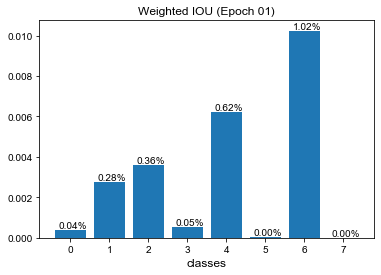

In [213]:
iou_rate = iou1['inter']/iou1['union']*WEIGHT
plot_iou(iou_rate, 1, iou_dir)

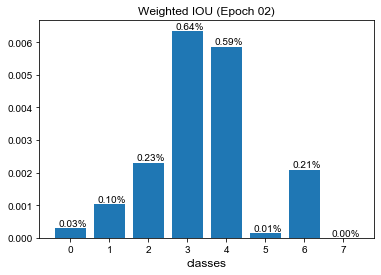

In [212]:
iou_rate = iou2['inter']/iou2['union']*WEIGHT
plot_iou(iou_rate, 2, iou_dir)

In [4]:
def generate_iou_gif(iou_dir=''):
    filenames = glob.glob(os.path.join(iou_dir,'iou_epoch*')) #完整路径，同时避免.DS_stores等隐藏文件
    filenames = sorted(filenames) #确保按顺序
    plots = []
    for filename in filenames:
        plots.append(plt.imread(filename))
    imageio.mimsave(os.path.join(iou_dir, 'iou.gif'), plots, 'GIF-FI', fps=2)
    display(IPyImage(open(os.path.join(iou_dir, 'iou.gif'), 'rb').read())) #显示动画

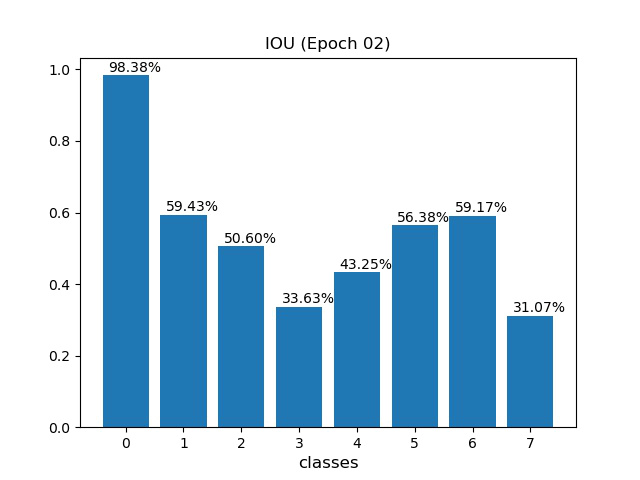

In [8]:
generate_iou_gif('running_log/deeplabv3p_resnet101/iou_plots')

#### Train

`train/train_infer.py`

In [ ]:
def train_on_epoch(model, train_loader, optimizer, device, epoch, iou_dir, iter_smooth=100):
    epoch_ce_loss = 0
    # epoch_focal_loss = 0
    epoch_dice_loss = 0
    epoch_iou = {'inter':0.,'union':0.} #由于每个batch的pixels数不固定，需要累积求epoch均值
    n_batches = len(train_loader)
    # start = time.time()
    for i, (image, mask) in enumerate(train_loader):
        model.train() #训练模式
        image = image.to(device) #(b,c,h,w)
        mask = mask.to(device) #(b,h,w)
        # print(f'Loading time: {time.time()-start}')
        
        # start = time.time()
        # 计算分割结果和iou
        y_pred = model(image) #(b,n_classes,h,w)
        ce_loss = F.cross_entropy(y_pred, mask, WEIGHT)
        # focal_loss = FocalLoss()(y_pred, mask, WEIGHT)
        dice_loss = DiceLoss()(y_pred, mask, WEIGHT)
        loss = ce_loss+dice_loss
        # loss = 20*focal_loss+dice_loss
        mean_iou, iou = calculate_mean_iou(y_pred, mask)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(f'Processing time: {time.time()-start}')
        epoch_ce_loss += ce_loss.item()
        # epoch_focal_loss += focal_loss.item()
        epoch_dice_loss += dice_loss.item()
        epoch_iou['inter']+=iou['inter']#.detach()
        epoch_iou['union']+=iou['union']#.detach()
        if i%iter_smooth==0:
            print(f'Batch {i+1}/{n_batches} - ce_loss: {epoch_ce_loss/(i+1):.3f} - dice_loss: {epoch_dice_loss/(i+1):.3f} - mean_iou: {mean_iou:.3f}') 
            # print(f'Batch {i+1}/{n_batches} - focal_loss: {epoch_focal_loss/(i+1):.3f} - dice_loss: {epoch_dice_loss/(i+1):.3f} - mean_iou: {mean_iou:.3f}') 
        # start = time.time()
    

    #仅在drop last的时候有效，否则求loss时reduction=‘none'，再除以样本总数
    epoch_ce_loss /= n_batches
    # epoch_focal_loss /= n_batches 
    epoch_dice_loss /= n_batches 
    epoch_iou = (epoch_iou['inter']/epoch_iou['union']).cpu().numpy() 
    epoch_mean_iou = np.mean(epoch_iou)
    return epoch_ce_loss, epoch_dice_loss, epoch_mean_iou
    # return epoch_focal_loss, epoch_dice_loss, epoch_mean_iou
    

In [ ]:
def val_on_epoch(model, valid_loader, device, epoch, iou_dir):
    val_ce_loss = 0
    # val_focal_loss = 0
    val_dice_loss = 0
    val_iou = {'inter':0.,'union':0.}
    n_samples = 0
    for i, (image, mask) in enumerate(valid_loader):
        model.eval() #预测模式，关闭dropout和bn
        image = image.to(device)
        mask = mask.to(device)
        n_samples += image.shape[0]
        with torch.no_grad():
            y_pred = model(image) 
            #由于val batch没有drop last，先求样本loss总和，再求样本loss均值
            ce_loss = F.cross_entropy(y_pred, mask, WEIGHT, reduction='sum')
            # focal_loss = FocalLoss()(y_pred, mask, WEIGHT, reduction='sum')
            dice_loss = DiceLoss()(y_pred, mask, WEIGHT, reduction='sum')
            val_ce_loss += ce_loss.item()
            # val_focal_loss += focal_loss.item() #样本loss总和
            val_dice_loss += dice_loss.item()
            mean_iou, iou = calculate_mean_iou(y_pred, mask)
        
            # print(f'Processing time: {time.time()-start}')
            val_iou['inter']+=iou['inter']#.detach().cpu()
            val_iou['union']+=iou['union']#.detach().cpu()
    
    b,c,h,w = image.shape
    val_ce_loss = val_ce_loss/(n_samples*h*w)
    # val_focal_loss = val_focal_loss/(n_samples*h*w)
    val_dice_loss = val_dice_loss/(n_samples*NUM_CLASSES)
    val_iou = (val_iou['inter']/val_iou['union']).cpu().numpy() #每个类别的iou
    val_mean_iou = np.mean(val_iou)
    plot_iou(val_iou, epoch+1, iou_dir)
    print(f"Validation - ce_loss: {val_ce_loss:.3f} - dice_loss: {val_dice_loss:.3f} - mean_iou: {val_mean_iou:.3f} - iou: {', '.join([f'{i:.2f}'for i in val_iou])}")   
    # print(f"Validation - focal_loss: {val_focal_loss:.3f} - dice_loss: {val_dice_loss:.3f} - mean_iou: {val_mean_iou:.3f} - iou: {', '.join([f'{i:.2f}'for i in val_iou])}")   
    return val_ce_loss, val_dice_loss, val_mean_iou, val_iou
    # return val_focal_loss, val_dice_loss, val_mean_iou, val_iou
    

In [ ]:
def predict(model, image, device, color_mode=True): #根据face_align预测emb
    model.eval() #[0,255] (h,w,c)
    image = crop_and_resize(image)
    image = test_transform(image)[np.newaxis,...] #[0,1] (1,c,h,w)
    image = image.to(device)
    with torch.no_grad():
        y_pred = model(image) #(1,c,h,w)
        y_pred = torch.argmax(y_pred.detach().cpu(), dim=1).squeeze(0) #(h,w)
        y_pred = y_pred.numpy()
        if color_mode:
            mask = expand_resize_color_mask(y_pred)
        else:
            mask = expand_resize_mask(y_pred)
    return mask

>### Demo

#### Utils
`utils.py`

In [ ]:
def time_to_str(t):
    hr = int(t/60)//60
    minute = int(t/60)%60
    sec = int(t)%60   
    return f'{hr:02}h {minute:02}m {sec:02}s'

In [ ]:
class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout  #在终端的输出
        self.file = None

    def open(self, file, mode='w'): #默认新建日志
        self.file = open(file, mode)

    def write(self, message, is_terminal=0, is_file=1):
        if is_terminal == 1:
            self.terminal.write(message) #在终端输出日志
            self.terminal.flush()
            #time.sleep(1)

        if is_file == 1:
            self.file.write(message) #在文件输出日志
            self.file.flush()

#### Main
`main.py`

In [ ]:
import sys
import argparse
import pickle

In [ ]:
if device.__str__() == 'cuda':
    num_workers = 4 #deeplabv3p用4，unetpp用3
    pin_memory = True #使用锁页内存加速复制数据到gpu
else: #AIStudio终端查看df -h可以看到在CPU配置下，shm只有64m，需要增加limit防止爆内存docker run--shm-size 8g，若没有权限，需要设置num_workers=0
    num_workers = 0
    pin_memory = False

In [ ]:
def run_train(config):
    # ------setup------
    out_dir = 'running_log' #保存训练日志和模型的路径
    model_name = f"{config.model}_{config.backbone}"
    out_dir = os.path.join(out_dir, model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
    if not os.path.exists(checkpoint_dir): 
        os.makedirs(checkpoint_dir) #多层创建文件夹
   
    log = Logger()
    log.open(os.path.join(out_dir, f'{model_name}_training.txt'), mode='a') #增加内容
    log.write(f'Training log @ {out_dir}\n')
    log.write(f'Device: {device}\n')
    log.write('\n')

    #------dataset------
    log.write('** Dataset setting **\n')
    train_dataset = LaneDataset(transform=train_transform, mode='train')
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, 
                              drop_last=True, num_workers=num_workers, pin_memory=pin_memory)
    valid_dataset = LaneDataset(transform=test_transform, mode='test')
    valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE//2, 
                              drop_last=False, num_workers=num_workers, pin_memory=pin_memory)
    log.write(f'training_samples = {train_dataset.__len__()}\n')
    log.write(f'val_samples = {valid_dataset.__len__()}\n')
    log.write(f'batch_size = {BATCH_SIZE}\n')
    log.write('\n')
    
    #------model------
    log.write('** Model setting **\n')
    model = get_model(config.model, config.backbone, OUTPUT_STRIDE, DILATION, PRETRAINED, UNET_LAYER)
    log.write(f'Model: {type(model).__name__} ({config.backbone})\n')
    if config.model=='deeplabv3':
        log.write(f'os = {OUTPUT_STRIDE}\n')
        log.write(f'dilation = {DILATION}\n')
    elif config.model=='unetpp':
        log.write(f'unet_layer = {UNET_LAYER}\n')
    model.to(device) #先分配给gpu
    log.write('\n')
    
    #------train------
    log.write('** Training setting **\n')
    criterion = get_criterion(name=CRITERION)
    optimizer = get_optimizer(model, name=OPTIMIZER)
    log.write(f'criterion = {CRITERION}\n')
    log.write(f'optimizer = {type(optimizer).__name__}\n')
    log.write(f'epochs = {config.epochs}\n')
    log.write('\n')

    #------pretrained------
    epoch_start = 0
    max_mean_iou = 0.0
    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        log.write(f'Loading initial_checkpoint: {pretrained_path}\n')
        checkpoint = torch.load(pretrained_path, device)
        model = load_model_checkpoint(model, checkpoint, device) #加载完之后，再用DP
        # 当训练意外中断时，加载方便继续训练
        optimizer = load_optimizer_checkpoint(optimizer, checkpoint, device)
        epoch_start = checkpoint['epoch']
        max_mean_iou = checkpoint['mean_iou']
        log.write('\n')

    model = nn.DataParallel(model) #gpu多于1个时，并行运算

    #------log------
    log.write('** Start training here! **\n')
    pattern1="{: ^12}|{:-^16}|{:-^62}|\n" #开头第一行
    pattern2="{: ^6}"*2+"|"+"{: ^8}"*2+"|"+"{: ^8}"*2+"{: ^46}"+"|"+"{: ^12}\n" #标题行
    pattern3="{: ^6}"+"{: ^6.0e}"+"|"+"{: ^8.4f}"*2+"|"+"{: ^8.4f}"*2+"{: ^46}"+"|"+"{: ^12}\n" #内容行
    log.write(pattern1.format('',' TRAIN ',' VALID '))
    log.write(pattern2.format('epoch','lr','loss','mean_iou','loss','mean_iou','iou', 'time'))
    log.write("-"*102+'\n')       
    
    history = defaultdict(list)
    val_loss, val_mean_iou, val_iou = 0,0,0 #前半周期不做validation
    start = time.time() #计时
    for e in range(epoch_start, epoch_start+config.epochs): #继续从上次的epoch训练 
        print(f'Epoch {e+1}/{epoch_start+config.epochs}')
        # 根据epoch先调整lr
        lr = adjust_learning_rate(optimizer, e)

        # 训练
        train_loss, train_mean_iou = train_on_epoch(model, train_loader, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_mean_iou'].append(train_mean_iou)
        
        # 验证
        if valid_loader and e >= config.epochs // 2: #由于前半周期肯定不断进步，只在下半周期做validation
            val_loss, val_mean_iou, val_iou = val_on_epoch(model, valid_loader, device)
            history['val_loss'].append(val_loss)
            history['val_mean_iou'].append(val_mean_iou)
            history['val_iou'].append(val_iou)
            
            end = time.time() #每个epoch结束后计算一次累计时间
            log.write(pattern3.format(e+1, lr, train_loss, train_mean_iou, val_loss, val_mean_iou, 
                                      ', '.join([f'{i:.2f}'for i in val_iou]), time_to_str(end - start)))
            
            if val_mean_iou > max_mean_iou:
                max_mean_iou = val_mean_iou #更新最大mean iou值
                ckpt_path = os.path.join(checkpoint_dir, f'global_max_mean_iou_model.pth') #仅保存一个最优模型
                torch.save({
                    'epoch':e+1, 
                    'mean_iou': max_mean_iou,
                    'model':type(model.module).__name__,
                    'state_dict': model.module.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)
                log.write(f'Saving epoch {e+1} max mean iou model: {max_mean_iou:.4f}\n')
        else:
            end = time.time() #每个epoch结束后计算一次累计时间
            log.write(pattern3.format(e+1, lr, train_loss, train_mean_iou, val_loss, val_mean_iou, 
                                      ', '.join([f'{i:.2f}'for i in val_iou]), time_to_str(end - start)))
            
    # 保存每个epoch的metrics结果，方便后续可视化查看训练情况
    pickle.dump(history, open(os.path.join(out_dir, f'{model_name}_history.pkl'),'wb'))

In [ ]:
def run_test(config):
    out_dir = 'running_log' #保存训练日志和模型的路径
    model_name = f"{config.model}_{config.backbone}"
    out_dir = os.path.join(out_dir, model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
         
    model = get_model(config.model, config.backbone, OUTPUT_STRIDE, DILATION, PRETRAINED, UNET_LAYER)
    model.to(device) #先分配给gpu
    
    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        print(f'Loading initial_checkpoint: {pretrained_path}\n')
        checkpoint = torch.load(pretrained_path, device)
        model = load_model_checkpoint(model, checkpoint, device) 
    model = nn.DataParallel(model) 
    
    image_path = os.path.join(DATA_ROOT, TEST_PATH, config.image_path)
    image = cv2.imread(image_path)
    mask = predict(model, image, device, config.color_mode) #得到真人的概率
    
    print('Rendering...')
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(image[...,::-1]) 
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray') 
    
    if config.save:
        save_path = os.path.join(DATA_ROOT, PRED_PATH, os.path.splitext(config.image_path)[0]+f'{"_color" if config.color_mode else ""}_mask.jpg')
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR) #把mask从RGB转为BGR
        cv2.imwrite(save_path, mask)
        print('Prediction mask saved.')
    return mask

In [ ]:
def main(config):
    if config.mode == 'train':
        run_train(config)
    if config.mode == 'infer':
        return run_test(config)

In [ ]:
if __name__ == '__main__':
    # 在终端传入参数运行模型
    parser = argparse.ArgumentParser()
    
    # model
    parser.add_argument('--model', type=str, default='deeplabv3p', choices=['deeplabv3p','unetpp'])
    parser.add_argument('--backbone', type=str, default='', choices=['resnet18','resnet34','resnet50','resnet101','resnet152'])
    
    # train
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--mode', type=str, default='train', choices=['train','infer'])
    parser.add_argument('--pretrained_model', type=str, default=None) #预训练模型路径 global_min_acer_model.pth
    
    # test
    parser.add_argument('--image_path', type=str, default=None) #预测图片路径
    parser.add_argument('--color_mode', type=bool, default=False) #预测图片路径
    parser.add_argument('--save', type=bool, default=True) #保存预测mask
    
    config = parser.parse_args()
    print(config)
    main(config)

> ### Evaluation

UNet++目前即便调整到最小的batch_size=2，而且单进程读取数据，依然爆16G显存，需要进一步了解原因：

| 模型 | 骨干 | OS | Dilation | Mean IOU | IOU |
| -- | -- | -- | -- |-- |-- | 
| DeepLabV3| Resnet101 |16|[1,2,4]| 0.7119| 0.99, 0.75, 0.66, 0.60, 0.56, 0.73, 0.77, 0.63|
| UNet| Resnet50 |-|-  |
| UNet++ (L4) | Resnet50 |-|-  |


>### Deployment

#### Pretrained Model

`lane_segmentation.py`：训练完成后，把效果最好的模型整理入文档，方便后续调用。

In [42]:
import os
import sys
sys.path.append('./model') #增加绝对路径
sys.path.append('./preprocess')
sys.path.append('./train')
from summary import *
from config import *
from train.train_infer import *

In [43]:
class LaneSegmentation():
    def __init__(self, name='deeplabv3p'):
        super(LaneSegmentation, self).__init__()
        # 加载预训练模型
        pretrained_models = {'deeplabv3p': {'setting':('deeplabv3p','resnet101',16,[1,2,4],False,4),
                                           'checkpoint': os.path.join('running_log','deeplabv3p_resnet101', 'checkpoint', 'global_max_mean_iou_model.pth')},
                             'unetpp': {'setting':('unetpp','resnet50',16,[1,2,4],False,4),
                                        'checkpoint': os.path.join('running_log','unetpp_resnet50', 'checkpoint', 'global_max_mean_iou_model.pth')}}
        self.model = get_model(*pretrained_models[name]['setting'])
        self.pretrained_path = pretrained_models[name]['checkpoint'] #为了后续可以转变成其他模型格式时，保存使用
        checkpoint = torch.load(self.pretrained_path, device)
        self.model = load_model_checkpoint(self.model, checkpoint, device) 
        self.model.to(device) 
      
    def get_mask(self, image, color_mode=True): 
        mask = predict(self.model, image, device, color_mode) 
        return mask

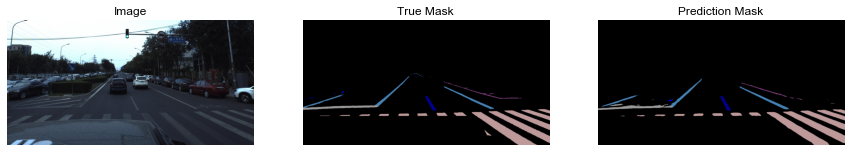

In [45]:
# 调用车道线分割模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lane_seg = LaneSegmentation()
image = cv2.imread('dataset/Test/170927_064448626_Camera_6.jpg')
mask = lane_seg.get_mask(image)
true_mask = plt.imread('dataset/Prediction/170927_064448626_Camera_6_bin_converted.png')
plots = [image[...,::-1], true_mask, mask]
titles = ['Image', 'True Mask', 'Prediction Mask']
plt.figure(figsize=(15,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(plots[i])
    plt.title(titles[i])
    plt.axis('off')
plt.show();

#### Video
`demo_video.py`

In [19]:
from IPython.display import Video

In [39]:
def show_material(frame, offset=200): #检查需要预测的行车记录仪视频素材
    #参考训练集的画面，先把下半部分有大量车头的区域去掉，再resize成训练图大小
    crop_frame = cv2.resize(frame[:-offset,:], IMAGE_SIZE) #(720, 1280, 3)
    crop_frame = crop_and_resize(crop_frame) #(1710, 3384)
    images = [frame, crop_frame]
    plt.figure(figsize=(10,4))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i][...,::-1])
        plt.title(images[i].shape)
        plt.axis('off')
    # plt.show()

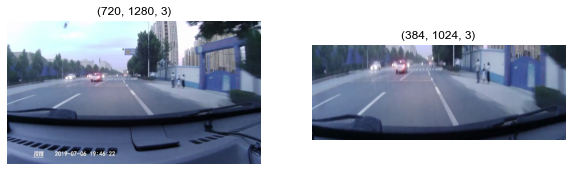

In [348]:
cap = cv2.VideoCapture('dataset/Test/video.flv') #从视频中读取图像
for i in range(100): #遍历到第100帧画面
    normal, frame = cap.read() #(720, 1280, 3)
show_material(frame)

In [ ]:
class LaneSegmentationVideo():
    def __init__(self, model='deeplabv3p'):
        super(LaneSegmentationVideo, self).__init__()
        self.lane_seg = LaneSegmentation(model)
    
    def get_mask(self, video_path=None, offset=200, save=False):
        # 选择视频流
        if video_path:
            cap = cv2.VideoCapture(video_path) #从视频中读取图像
            # save_video = os.path.splitext(video_path)[0]+'_mask.avi' #单独mask视频
            save_video_combined = os.path.splitext(video_path)[0]+'_mask_combined.avi' #mask和原视频并列
            save_image = os.path.splitext(video_path)[0]+'_mask.jpg'
        else:
            cap = cv2.VideoCapture(0) #调用电脑连接的第0个摄像头(通常为前置）
            # save_video = os.path.join(DATA_ROOT, TEST_PATH, 'webcam_mask.avi')
            save_video_combined = os.path.join(DATA_ROOT, TEST_PATH,'webcam_mask_combined.avi') #mask和原视频并
            save_image = os.path.join(DATA_ROOT, TEST_PATH,'webcam_mask.jpg')
        
        # 视频属性
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        # avi视频：YUV编码*‘I420’，MPEG-1编码*‘PIMI’，MPEG-4编码*'XVID'
        # flv视频：*‘FLV1’
        fps = cap.get(cv2.CAP_PROP_FPS) 
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        # out_mask = cv2.VideoWriter(save_video, fourcc, fps, (w,h)) #一般为(1280,720)
        out_combined = cv2.VideoWriter(save_video_combined, fourcc, fps, (w,h*2)) #一般为(1280,720)
        
        # 读取视频流
        while cap.isOpened(): #正常打开
            normal, frame = cap.read()
            if not normal: #如果视频播放结束，跳出循环
                break 

            # 预测
            image = cv2.resize(frame[:-offset,:], IMAGE_SIZE) #resize成指定大小
            mask = self.lane_seg.get_mask(image) #(h',w',3)的RGB
            mask = cv2.resize(mask, (w, h-offset), interpolation=cv2.INTER_NEAREST) #恢复剪裁后尺寸
            final_mask = np.zeros((h,w,3), dtype='uint8') #恢复原尺寸
            final_mask[:-offset, ...] = mask
            final_mask = cv2.cvtColor(final_mask, cv2.COLOR_RGB2BGR) #把mask从RGB转为BGR
            combined = cv2.vconcat([frame, final_mask]) 

            # 输出画面
            # cv2.imshow('We are inferring lane mask ... (Press "q" to quick)', final_mask)
            
            # 保存
            if save:
                # out_mask.write(final_mask) #逐帧保存 
                out_combined.write(combined)
            if cv2.waitKey(1) & 0xff == ord('q'): #维持窗口，实时检测，按q退出
                break
                
        cv2.imwrite(save_image, final_mask) #保存截图
        # plt.imshow(final_mask[...,::-1]) #把最后一张图片以RGB显示出来
        # plt.axis('off')
        # plt.show()
        cap.release() #断开视频/摄像头
        # out_mask.release()
        out_combined.release()
        cv2.destroyAllWindows() #关闭所有窗口
        # cv2.waitKey(1) #只用在Jupyter上，防止kernel奔溃


def show_material(frame, offset=200): #检查需要预测的行车记录仪视频素材
    #参考训练集的画面，先把下半部分有大量车头的区域去掉，再resize成训练图大小
    crop_frame = cv2.resize(frame[:-offset,:], IMAGE_SIZE) #(720, 1280, 3)
    crop_frame = crop_and_resize(crop_frame) #(1710, 3384)
    images = [frame, crop_frame]
    plt.figure(figsize=(10,4))
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(images[i][...,::-1])
        plt.title(images[i].shape)
        plt.axis('off')
    # plt.show()


In [ ]:
seg = LaneSegmentationVideo()
seg.get_mask('dataset/Test/video.flv', save=True)

为了方便比较，拼接视频截图效果如下：

<img src='dataset/Prediction/video_mask_combined.jpg' width=400></img>

#### Mobile
`demo_onnx.py`

In [80]:
from torch import onnx

In [98]:
def torch2onnx(name):
    # 加载模型
    lane_seg = LaneSegmentation(name)
    model = lane_seg.model 
    
    # 模拟输入
    dummy_image  = np.random.randint(0,256,[IMAGE_SIZE[1],IMAGE_SIZE[0],3], dtype=np.uint8) # 模型输入维度为(1, 3, 224, 224)
    dummy_image = crop_and_resize(dummy_image)
    dummy_image = test_transform(dummy_image)[np.newaxis,...] #[0,1] (1,c,h,w)
    dummy_image = dummy_image.to(device)
    
    # 导出模型为ONNX格式，通过运行一次模型获得模型的执行轨迹
    save_path = os.path.splitext(lane_seg.pretrained_path)[0]+'.onnx'
    onnx.export(model, dummy_image, save_path, opset_version=11, verbose=True, 
                input_names=['image'], output_names=['mask'])


In [99]:
torch2onnx('deeplabv3p')

graph(%image : Float(1, 3, 384, 1024, strides=[1179648, 393216, 1024, 1], requires_grad=0, device=cpu),
      %classifier.weight : Float(8, 256, 1, 1, strides=[256, 1, 1, 1], requires_grad=1, device=cpu),
      %classifier.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %1258 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %1259 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %1261 : Float(64, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=0, device=cpu),
      %1262 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %1264 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %1265 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %1267 : Float(256, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=0, device=cpu),
      %1268 : Float(256, strides=[1], requires_grad=0, device=cpu),
      %1270 : Float(256, 64, 1, 1, strides=[64, 1, 1, 1], requires_grad=0, device=cpu),
      %127

#### Web Server
`demo_flask.py`

In [100]:
import base64
from PIL import Image
import io 
from flask import Flask, render_template, request

In [ ]:
app = Flask(__name__)

@app.route('/') #在根地址时
def index(): #自动调用以下函数
    return render_template('index.html')

@app.route('/infer', methods = ['GET', 'POST']) #在推理地址下
def infer(name='deeplabv3p'):
    if request.method == 'POST': #从index.html接收到图片路径
        lane_seg = LaneSegmentation(name)
        f = request.files['image_path'] 
        buffer = io.BytesIO(f.read()) #读取为<class '_io.BytesIO'>
        image = np.array(Image.open(buffer))[...,::-1] #缓存->BGR数组
        mask = lane_seg.get_mask(image)
        mask = Image.fromarray(mask) #变成PIL图
        
        buffer = io.BytesIO() #创建缓存
        mask.save(buffer, format='JPEG') #保存jpg图到缓存
        buffer = buffer.getvalue() #得到缓存的内容
        b64data = base64.b64encode(buffer).decode('utf-8') #编码再解码
        return render_template('infer.html', b64data=b64data) #调用infer.html页面
    
if __name__ == "__main__":
    app.run(port=8080) 
    #自定义指定host和端口，执行网页 

`index.html`

`infer.html`

预测效果页面如下：   
<img src='note/website.png' width=500></img>